<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/TradingRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## GDrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
folder = '/content/drive/My Drive/FintechData/RL/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## TensorFlow Version

In [0]:
%tensorflow_version 1.x

## Import Libraray

In [3]:
import random
import os
import math
import logging
import pandas as pd
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader.data  as pdr

from collections import deque
from keras.models import Sequential
from keras.models import load_model, clone_model
from keras.layers import Dense
from keras.optimizers import Adam
from tqdm import tqdm
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]


Using TensorFlow backend.


# Renforcmenet Learning

## Utils

In [0]:
# Formats Position
format_position = lambda price: ('-$' if price < 0 else '+$') + '{0:.2f}'.format(abs(price))


# Formats Currency
format_currency = lambda price: '${0:.2f}'.format(abs(price))


def show_train_result(result, val_position, initial_offset):
    ''' 
    Displays training results
    '''
    if val_position == initial_offset or val_position == 0.0:
        print('Episode {}/{} - Train Position: {}  Val Position: USELESS  Train Loss: {:.4f}'
                     .format(result[0], result[1], format_position(result[2]), result[3]))
    else:
        print('Episode {}/{} - Train Position: {}  Val Position: {}  Train Loss: {:.4f})'
                     .format(result[0], result[1], format_position(result[2]), format_position(val_position), result[3],))


def show_eval_result(model_name, profit, initial_offset):
    '''
    Displays eval results
    '''
    if profit == initial_offset or profit == 0.0:
        print('{}: USELESS\n'.format(model_name))
    else:
        print('{}: {}\n'.format(model_name, format_position(profit)))

def switch_k_backend_device():
    '''
    Switches `keras` backend from GPU to CPU if required.
    Faster computation on CPU (if using tensorflow-gpu).
    '''
    if K.backend() == "tensorflow":
        logging.debug("switching to TensorFlow for CPU")
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


## Agent

In [0]:
def huber_loss(y_true, y_pred, clip_delta=1.0):
    '''
    Huber loss - Custom Loss Function for Q Learning
    Links: 	https://en.wikipedia.org/wiki/Huber_loss
            https://jaromiru.com/2017/05/27/on-using-huber-loss-in-deep-q-learning/
    '''
    error = y_true - y_pred
    cond = K.abs(error) <= clip_delta
    squared_loss = 0.5 * K.square(error)
    quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
    return K.mean(tf.where(cond, squared_loss, quadratic_loss))

class Agent:
    ''' 
    Stock Trading Bot 
    '''

    def __init__(self, 
                 state_size, 
                 strategy="t-dqn", 
                 reset_every=1000, 
                 pretrained=False, 
                 model_name=None):
        self.strategy = strategy

        # agent config
        self.state_size = state_size    	# normalized previous days
        self.action_size = 3           		# [sit, buy, sell]
        self.model_name = model_name
        self.inventory = []
        self.memory = deque(maxlen=10000)
        self.first_iter = True

        # model config
        self.model_name = model_name
        self.gamma = 0.95 # affinity for long term reward
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.loss = huber_loss
        self.custom_objects = {"huber_loss": huber_loss}  # important for loading the model from memory
        self.optimizer = Adam(lr=self.learning_rate)

        if pretrained and self.model_name is not None:
            self.model = self.load()
        else:
            self.model = self._model()

        # strategy config
        if self.strategy in ["t-dqn", "double-dqn"]:
            self.n_iter = 1
            self.reset_every = reset_every

            # target network
            self.target_model = clone_model(self.model)
            self.target_model.set_weights(self.model.get_weights())

    def _model(self):
        '''
        Creates the model
        '''
        model = Sequential()
        model.add(Dense(units=128, activation="relu", input_dim=self.state_size))
        model.add(Dense(units=256, activation="relu"))
        model.add(Dense(units=256, activation="relu"))
        model.add(Dense(units=128, activation="relu"))
        model.add(Dense(units=self.action_size))

        model.compile(loss=self.loss, optimizer=self.optimizer)
        return model

    def remember(self, state, action, reward, next_state, done):
        '''
        Adds relevant data to memory
        '''
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, is_eval=False):
        '''
        Take action from given possible set of actions
        '''
        # take random action in order to diversify experience at the beginning
        if not is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        if self.first_iter:
            self.first_iter = False
            return 1 # make a definite buy on the first iter

        action_probs = self.model.predict(state)
        return np.argmax(action_probs[0])

    def train_experience_replay(self, batch_size):
        '''
        Train on previous experiences in memory
        '''
        mini_batch = random.sample(self.memory, batch_size)
        X_train, y_train = [], []
        
        # DQN
        if self.strategy == "dqn":
            for state, action, reward, next_state, done in mini_batch:
                if done:
                    target = reward
                else:
                    # approximate deep q-learning equation
                    target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

                # estimate q-values based on current state
                q_values = self.model.predict(state)
                # update the target for current action based on discounted reward
                q_values[0][action] = target

                X_train.append(state[0])
                y_train.append(q_values[0])

        # DQN with fixed targets
        elif self.strategy == "t-dqn":
            if self.n_iter % self.reset_every == 0:
                # reset target model weights
                self.target_model.set_weights(self.model.get_weights())
            """
            for state, action, reward, next_state, done in mini_batch:
                if done:
                    target = reward
                else:
                    # approximate deep q-learning equation with fixed targets
                    target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])

                # estimate q-values based on current state
                q_values = self.model.predict(state)
                # update the target for current action based on discounted reward
                q_values[0][action] = target

                X_train.append(state[0])
                y_train.append(q_values[0])
            """
            states = np.array([tup[0][0] for tup in mini_batch])
            actions = np.array([tup[1] for tup in mini_batch])
            rewards = np.array([tup[2] for tup in mini_batch])
            next_states = np.array([tup[3][0] for tup in mini_batch])
            done = np.array([tup[4] for tup in mini_batch])

            # Q(s', a)
            target = rewards + self.gamma * np.amax(self.target_model.predict(next_states), axis=1)
            # end state target is reward itself (no lookahead)
            target[done] = rewards[done]

            # Q(s, a)
            q_values = self.model.predict(states)
            # make the agent to approximately map the current state to future discounted reward
            q_values[range(batch_size), actions] = target

            X_train = states
            y_train = q_values

        # Double DQN
        elif self.strategy == "double-dqn":
            if self.n_iter % self.reset_every == 0:
                # reset target model weights
                self.target_model.set_weights(self.model.get_weights())

            for state, action, reward, next_state, done in mini_batch:
                if done:
                    target = reward
                else:
                    # approximate double deep q-learning equation
                    target = reward + self.gamma * self.target_model.predict(next_state)[0][np.argmax(self.model.predict(next_state)[0])]

                # estimate q-values based on current state
                q_values = self.model.predict(state)
                # update the target for current action based on discounted reward
                q_values[0][action] = target

                X_train.append(state[0])
                y_train.append(q_values[0])
                
        else:
            raise NotImplementedError()

        # update q-function parameters based on huber loss gradient
        loss = self.model.fit(
            np.array(X_train),
            np.array(y_train),
            epochs=1, verbose=0
        ).history["loss"][0]

        # as the training goes on we want the agent to
        # make less random and more optimal decisions
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

    def save(self, episode):
        self.model.save(folder + "models/{}_{}".format(self.model_name, episode))

    def load(self):
        return load_model(folder + "models/" + self.model_name, custom_objects=self.custom_objects)

## Model

In [0]:
class Model():

    def __init__(self, ep_count=100, batch_size=32, window_size=10):
        self.ep_count = ep_count
        self.batch_size = batch_size
        self.window_size = window_size

    def set_agent(self, agent):
        self.agent = agent

    def sigmoid(self, x):
        """
        Performs sigmoid operation
        """
        try:
            if x < 0:
                return 1 - 1 / (1 + math.exp(x))
            return 1 / (1 + math.exp(-x))
        except Exception as err:
            print("Error in sigmoid: " + err)


    def get_state(self, data, t, n_days):
        """
        Returns an n-day state representation ending at time t
        """
        d = t - n_days + 1
        block = data[d: t + 1] if d >= 0 else -d * [data[0]] + data[0: t + 1]  # pad with t0
        res = []
        for i in range(n_days - 1):
            res.append(self.sigmoid(block[i + 1] - block[i]))
        return np.array([res])


    def train(self, episode, data):
        total_profit = 0
        data_length = len(data) - 1

        self.agent.inventory = []
        avg_loss = []

        state = self.get_state(data, 0, self.window_size + 1)

        for t in tqdm(range(data_length), total=data_length, leave=True, desc='Episode {}/{}'.format(episode, self.ep_count)):        
            reward = 0
            next_state = self.get_state(data, t + 1, window_size + 1)

            # select an action
            action = self.agent.act(state)

            # BUY
            if action == 1:
                self.agent.inventory.append(data[t])

            # SELL
            elif action == 2 and len(self.agent.inventory) > 0:
                self.agent.inventory.sort()
                bought_price = self.agent.inventory.pop(0)
                delta = data[t] - bought_price
                reward = delta #max(delta, 0)
                total_profit += delta

            # HOLD
            else:
                pass

            done = (t == data_length - 1)
            self.agent.remember(state, action, reward, next_state, done)

            if len(self.agent.memory) > batch_size:
                loss = self.agent.train_experience_replay(self.batch_size)
                avg_loss.append(loss)

            state = next_state

        if episode % 10 == 0:
            self.agent.save(episode)

        return (episode, self.ep_count, total_profit, np.mean(np.array(avg_loss)))


    def evaluate(self, data):
        total_profit = 0
        data_length = len(data) - 1

        history = []
        self.agent.inventory = []
        
        state = self.get_state(data, 0, self.window_size + 1)

        for t in range(data_length):        
            reward = 0
            next_state = self.get_state(data, t + 1, window_size + 1)
            # select an action
            action = self.agent.act(state, is_eval=True)

            # BUY
            if action == 1:
                self.agent.inventory.append(data[t])
                history.append((data[t], "BUY", total_profit))
            # SELL
            elif action == 2 and len(self.agent.inventory) > 0:
                self.agent.inventory.sort()
                bought_price = self.agent.inventory.pop(0)
                delta = data[t] - bought_price
                reward = delta #max(delta, 0)
                total_profit += delta
                history.append((data[t], "SELL", total_profit))
            # HOLD
            else:
                history.append((data[t], "HOLD", total_profit))

            done = (t == data_length - 1)
            self.agent.memory.append((state, action, reward, next_state, done))

            state = next_state
            if done:
                return total_profit, history


# Main

## Parameters

In [0]:
ticker = "GOOGL"
end_date = dt.date(2019, 12, 29)
start_date = end_date - dt.timedelta(365 * 20)
data = pdr.get_data_yahoo(ticker, start_date, end_date) 
valid_size_percentage = 10
test_size_percentage = 10
valid_size = int(valid_size_percentage/100 * data.shape[0])
test_size = int(test_size_percentage/100 * data.shape[0])
train_size = data.shape[0] - valid_size - test_size
window_size = 10
batch_size = 32
ep_count = 20
strategy = "t-dqn"
model_name = "model_debug"
model_name_eval = model_name + "_" + str(ep_count)

## Train


Trains the stock trading bot using Deep Q-Learning.
Please see https://arxiv.org/abs/1312.5602 for more details.
Args: [python train.py --help]

In [0]:
agent = Agent(window_size, strategy=strategy, pretrained=False, model_name=model_name)
model = Model(ep_count=ep_count, batch_size=batch_size, window_size=window_size)

In [18]:
model.set_agent(agent)

train_data = list(data[:train_size]['Adj Close'])
val_data = list(data[train_size:train_size+valid_size]['Adj Close'])

initial_offset = val_data[1] - val_data[0]

for episode in range(1, ep_count + 1):
    train_result = model.train(episode, train_data)
    #val_result, _ = model.evaluate(val_data)
    #show_train_result(train_result, val_result, initial_offset)


Episode 20/20: 100%|██████████| 3094/3094 [00:17<00:00, 181.23it/s]


## Evaluation

In [24]:
agent = Agent(window_size, pretrained=True, model_name=model_name_eval)
model.set_agent(agent)
switch_k_backend_device()
test_data = list(data[-test_size:]['Adj Close'])
initial_offset = test_data[1] - test_data[0]
test_result, history = model.evaluate(test_data)
show_eval_result(model_name, test_result, initial_offset)
history.append((None, None, None))
#display(history)
#display(test_result)

model_debug: +$5409.22



### Result

In [25]:
print ("Profit:", test_result)
# read csv into dataframe
result = pd.DataFrame({'price': data[-test_size:]['Adj Close'].values})
result['signal'] = [h[1] for h in history]
result['PnL'] = [h[2] for h in history]
result['buy'] = result['signal'] == 'BUY'
result['sell'] = result['signal'] == 'SELL'
result.dropna(inplace=True)

Profit: 5409.2200927734375


### Visualization

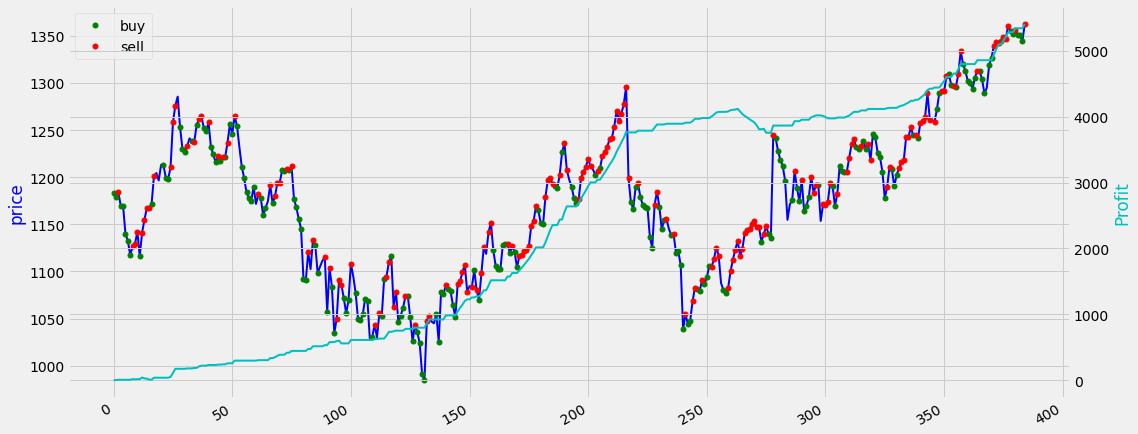

In [26]:
plt_data = result
index = plt_data['price'].index
fig, ax1 = plt.subplots()
ax1.plot(index, plt_data['price'], 'b-', linewidth=2) 
ax1.set_ylabel('price', color='b')

# Plot the buy signals
ax1.plot(plt_data.loc[plt_data.buy].index, plt_data['price'][plt_data.buy], 'o', markersize=5, color='g', label='buy')

# Plot the sell signals
ax1.plot(plt_data.loc[plt_data.sell].index, plt_data['price'][plt_data.sell], 'o', markersize=5, color='r', label='sell')
plt.legend()

fig.autofmt_xdate()

ax2 = ax1.twinx()
ax2.plot(index, plt_data['PnL'], 'c-', linewidth=2) 
ax2.set_ylabel('Profit', color='c')

plt.show()